<a href="https://colab.research.google.com/github/Hamid-Mofidi/PNP/blob/main/Bifurcation_of_lambda/bif_of_lam_new4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
from scipy.optimize import root
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
fixed_r = 2
k = 1 # k=1: bif of lambda_1,  k=2: bif of lambda_2


In [32]:
def equations(x):
    A, I, V, l = x

    # k = 1
    r =  fixed_r
    eps = 1e-15 #  a small number
    B      = l-A+r
    sqA    = np.sqrt(1+A**2)
    sqB    = np.sqrt(1+B**2) #assume that alpha=1/3, beta=2/3
    logAB  = np.log(np.maximum( B*(sqA-1), eps)/np.maximum( A*(sqB-1), eps) )
    rho    = (A-l)**2 + (sqA - sqB)*(A-l)
    sigma  = l/r
    logSBA = np.log(np.maximum( sigma*B , eps)/ np.maximum(A, eps) ) 
    siglog = 3*sigma*np.log( np.maximum( sigma, eps) )/(l*(sigma-1))

    gamma1  = 1/(I - (A-l) * sqA)
    gamma2  = 1/(I - (A-l) * sqB)
    
   
    ABGamma = A * gamma1 + B * gamma2
    ABGammaR= (1/A) * gamma1 + (1/B) * gamma2
    
    # partial_I_partial_A:
    term1_IA = I / (A - l)
    term2_IA = (I**2 - (A - l)**2) / logSBA * ABGammaR
    term3_IA = -(A - l) ** 2 / logSBA * ABGamma
    term4_IA =  (A - l) / logSBA
    
    par_I_par_A = term1_IA + term2_IA + term3_IA + term4_IA
    
    
    # partial_F_partial_I
    par_F_par_I = I * (gamma2 - gamma1) + rho / I
    
    
    #partial_F_partial_A:
    term1_FA = -(I ** 2 * (gamma2 - gamma1) + rho) / (A - l)
    term2_FA = - (A - l)
    term3_FA = (A - l) ** 2 * (A * gamma1 + B * gamma2)
    
    par_F_par_A =  term1_FA + term2_FA + term3_FA

    term1 =  np.log( np.maximum( I-(A-l)*sqB, eps) /np.maximum( I-(A-l)*sqA , eps) )  
    equation1 = rho - I * term1
    
    term2 = ((A - l) / logSBA) * (logAB - V + sqA - sqB + (A - l))
    equation2 = I - term2
    
    term3_1 = siglog * ((-1) ** k * I + (A - l))
    term3_2 = (-1) ** k * V - np.log(sigma)
    equation3 = term3_1 - term3_2

    term4_1 = (logSBA / (A - l)) * (par_F_par_A + par_F_par_I * par_I_par_A)
    term4_2 = siglog * ((-1) ** k * par_F_par_I - par_F_par_A)
    equation4 = term4_1 - term4_2

    return [equation1, equation2, equation3, equation4]



In [33]:
num_pts = 10
A_range = np.linspace(0.01, 10, num_pts)
I_range = np.linspace(-60, 60, num_pts)
V_range = np.linspace(-80, 80, num_pts)
l_range = np.linspace(0.01, 10, num_pts)

r = fixed_r
print(r)

Am = l_range + r

# Calculate the expressions
expression1 = (A_range - l_range) * np.sqrt(1 + A_range**2)
expression2 = (A_range - l_range) * np.sqrt(1 + (l_range - A_range + r)**2)

# Calculate the maximum and minimum expressions
max_expression = np.maximum(expression1, expression2)
min_expression = np.minimum(expression1, expression2)

eps = 1e-15 #  a small number
mask = ( (I_range > max_expression) | (I_range < min_expression) ) &\
(np.abs(I_range) > eps) & (A_range > eps) & (np.abs(l_range-r) > eps) &\
(l_range > eps)

#A_range = A_range[mask]
#I_range = I_range[mask]
#V_range = V_range[mask]
#l_range = l_range[mask]

# initialize arrays to store solutions
A_sol = []
I_sol = []
V_sol = []
l_sol = []

# Count the total number of iterations
total_iterations = len(A_range) * len(I_range) * len(l_range)

# Initialize tqdm
pbar = tqdm(total=total_iterations, mininterval=0.1)



import time

# Start the timer
start_time = time.time()

# loop through all combinations of initial values
for a in A_range:
    for i in I_range:
        for v in V_range:
            for ll in l_range:
                x0 = [a, i, v, ll]
                #def root_function(var):
                #    return equations([a, i, var, ll])
                # Solve for the variable component only
                #sol = root(root_function, x0[2], method='hybr')
                sol = root(equations, x0, method='hybr')
                # Calculate lmd1 and lmd2

                if sol.success: # check if solution was found
                    # check if solution satisfies the mask
                    expression12 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + sol.x[0]**2)
                    expression22 = (sol.x[0] - sol.x[3]) * np.sqrt(1 + (sol.x[3] - sol.x[0] + r)**2)
                    max_expression2 = np.maximum(expression12, expression22)
                    min_expression2 = np.minimum(expression12, expression22)

                    lmd1_sol = 3*(sol.x[3] - sol.x[0] + sol.x[1]) * \
                     (np.log(np.maximum(sol.x[3]/r, 1e-15))) / \
                     ((sol.x[3] - r) * (sol.x[2] +  np.log(sol.x[3]) - np.log(r)  ))

                    lmd2_sol = 3*(sol.x[3] - sol.x[0] - sol.x[1]) * \
                    (np.log(sol.x[3]) - np.log(r)) / \
                       ((sol.x[3] - r) * (-sol.x[2] + np.log(sol.x[3]) - np.log(r)  ))

                    mask2 =  ( (sol.x[1] > max_expression2) | (sol.x[1] < min_expression2) ) &\
                    (np.abs(sol.x[1]) > eps) & (sol.x[0] > 0) &  (np.abs(sol.x[3]-r) > eps)   &\
                    (sol.x[3] > 0) & (sol.x[0] < 0.5 * (sol.x[3] +r) )  & (lmd1_sol < lmd2_sol)
                    if np.all(mask2): # only append if all elements of mask are True
                        A_sol = np.append(A_sol, sol.x[0])
                        I_sol = np.append(I_sol, sol.x[1])
                        V_sol = np.append(V_sol, sol.x[2])
                        l_sol = np.append(l_sol, sol.x[3])


                      # Update tqdm progress
                    pbar.update(1)
    pbar.update(1)
# Close tqdm
pbar.close()

2


  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_108/819794016.py:24: RuntimeWarning: divide by zero encountered in scalar divide
  term1_IA = I / (A - l)
/tmp/ipykernel_108/819794016.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  term2_IA = (I**2 - (A - l)**2) / logSBA * ABGammaR
/tmp/ipykernel_108/819794016.py:26: RuntimeWarning: invalid value encountered in scalar divide
  term3_IA = -(A - l) ** 2 / logSBA * ABGamma
/tmp/ipykernel_108/819794016.py:27: RuntimeWarning: invalid value encountered in scalar divide
  term4_IA =  (A - l) / logSBA
/tmp/ipykernel_108/819794016.py:37: RuntimeWarning: invalid value encountered in scalar divide
  term1_FA = -(I ** 2 * (gamma2 - gamma1) + rho) / (A - l)
/tmp/ipykernel_108/819794016.py:46: RuntimeWarning: invalid value encountered in scalar divide
  term2 = ((A - l) / logSBA) * (logAB - V + sqA - sqB + (A - l))
/tmp/ipykernel_108/819794016.py:53: RuntimeWarning: invalid value encountered in scalar divide
  term4_1 = (l

In [34]:
r = fixed_r
print('The right boundary concentration r is: ', r)
print(r'The solutions are based on the bifurcation of $\lambda_{k}$ where $k$ is:', k)

The right boundary concentration r is:  2
The solutions are based on the bifurcation of $\lambda_{k}$ where $k$ is: 1


In [35]:
# Calculate the time passing
end_time = time.time()
time_passing = end_time - start_time
print("Time passing:", time_passing, "seconds")

Time passing: 103.48150157928467 seconds


In [36]:

print(np.shape(A_sol))
#print('A[0:num_pts] = ', A_sol[0:])
print('min(A) =',np.min(A_sol))
print('max(A) =',np.max(A_sol))
#print('The second max of A is =',np.partition(A_sol,-50)[-50:-40])
print('type of A is', type(A_sol))

print(np.shape(l_sol))
#print('l[0:num_pts] = ', l_sol[0:])
print('min(l) =',np.min(l_sol))
print('max(l) =',np.max(l_sol))
#print('The second max of l is =',np.partition(l_sol,-550)[-550:-520])
print('type of l is', type(l_sol))

print(np.shape(V_sol))
#print('V[0:10] = ', V_sol[0:])
print('min(V) =',np.min(V_sol))
print('max(V) =',np.max(V_sol))
#print('The second max of V is =',np.partition(V_sol,-50)[-50:-40])
print('type of V is', type(V_sol))

print(np.shape(I_sol))
#print('I[0:10] = ', I_sol[0:])
print('min(I) =',np.min(I_sol))
print('max(I) =',np.max(I_sol))
#print('The second max of I is =',np.partition(I_sol,-50)[-50:-40])





(742,)
min(A) = 0.39899641889171367
max(A) = 2.000000621407781
type of A is <class 'numpy.ndarray'>
(742,)
min(l) = 0.39899659146529926
max(l) = 2.0000037898364305
type of l is <class 'numpy.ndarray'>
(742,)
min(V) = -835.0200542274549
max(V) = 5.592318158801983e-06
type of V is <class 'numpy.ndarray'>
(742,)
min(I) = -276.9835778961061
max(I) = 5.026951941621417e-06


In [112]:
# Convert lists to numpy arrays for sorting
A_sol = np.array(A_sol)
I_sol = np.array(I_sol)
V_sol = np.array(V_sol)
l_sol = np.array(l_sol)

# Get the sorted indices for V_sol
sorted_indices = np.argsort(V_sol)

# Reorder arrays based on sorted indices
A_sol_ord = A_sol[sorted_indices] 
I_sol_ord = I_sol[sorted_indices]
V_sol_ord = V_sol[sorted_indices]
l_sol_ord = l_sol[sorted_indices]  
#print(V_sol_ord[10:100])


In [120]:
A_sol_ord = A_sol_ord[10:]
I_sol_ord = I_sol_ord[10:]
V_sol_ord = V_sol_ord[10:]
l_sol_ord = l_sol_ord[10:]

print('The length of V is:', len(V_sol_ord))

print('Pick a bifurcation point from 0 to len(V_sol_ord):')
bifp = 100
print('This is a bifurcation point: A, I, V, l = ', A_sol_ord[bifp],I_sol_ord[bifp],V_sol_ord[bifp],l_sol_ord[bifp])


The length of V is: 682
Pick a bifurcation point from 0 to len(V_sol_ord):
This is a bifurcation point: A, I, V, l =  1.5683520994344837 -1.338050031984322 -2.017811568638257 1.5683521057992247


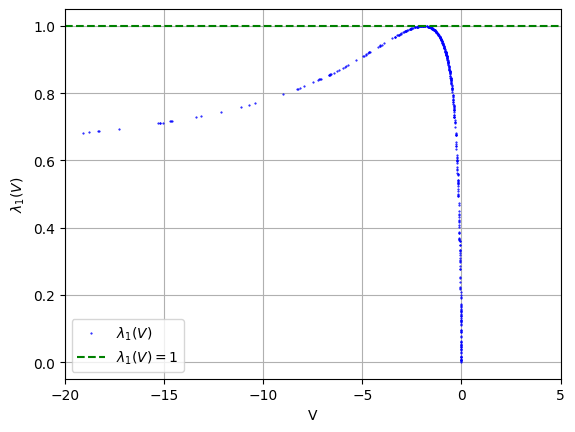

In [138]:
# Define constants
alpha = 1/3
l0 = l_sol_ord[100]
I0 = I_sol_ord[100]
A0 = A_sol_ord[100]
r0 = fixed_r

#V_values = np.linspace(-20, 20, 1000)

j_k = 0.5 * (l0 - A0 + (-1) ** (k + 1) * I_sol_ord)
j_k_0 = alpha * (l0 - r0) * ((-1) ** (k + 1) * V_sol_ord + np.log(l0) - np.log(r0)) / (2 * (np.log(l0) - np.log(r0)))

lmd_k = j_k / j_k_0


end = 218
# Plot lambda_k(V) versus V for k = 1
plt.plot(V_sol_ord[:-end], lmd_k[:-end], label=r'$\lambda_1(V)$', color='blue', linestyle='None', marker='.', markersize=1)
# Add horizontal line at lambda_k(V) = 1
plt.axhline(y=1, color='green', linestyle='--', label=r'$\lambda_1(V) = 1$')
# Add text on top of the horizontal line
#plt.text(1.1, 0.93, r'$\lambda_1(V) = 1$', fontsize=12, color='green')


plt.xlabel('V')
plt.ylabel(r'$\lambda_1(V)$')
plt.xlim(-20, 5)
#plt.ylim(0.6, 1.2)
#plt.title('Plot of $\lambda_1(V)$ versus V')
plt.legend()
plt.grid(True)
plt.show()


In [139]:

# Calculate lmd1 and lmd2
lmd1 = 3*(l_sol_ord - A_sol_ord + I_sol_ord) * \
       (np.log(np.maximum(l_sol_ord/r, 1e-15))) / \
       ((l_sol_ord - r) * ( V_sol_ord + np.log(l_sol_ord) - np.log(r)   ))

lmd2 = 3*(l_sol_ord - A_sol_ord - I_sol_ord) * \
       (np.log(np.maximum(l_sol_ord/r, 1e-15))) / \
       ((l_sol_ord - r) * (-V_sol_ord + np.log(l_sol_ord) - np.log(r)   ))

J1 = (l_sol_ord - A_sol_ord + I_sol_ord) /2
J2 = (l_sol_ord - A_sol_ord - I_sol_ord) /2

# Generate t vector
t = np.arange(len(lmd1))

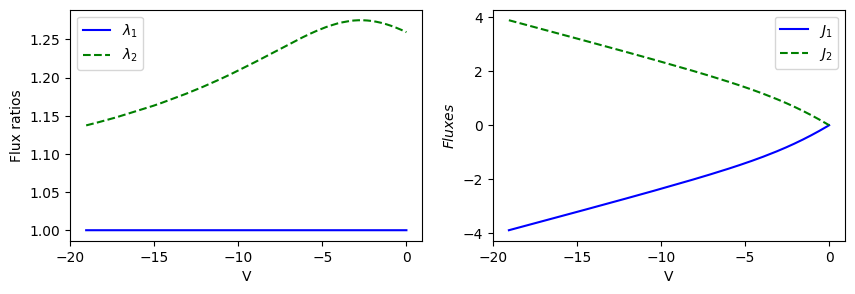

In [141]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

#axs[0, 0].scatter(V_sol_ord, lmd1, label='$\lambda_1$',s=1, color='red')
axs[0, 0].plot(V_sol_ord[:-end], lmd1[:-end], color='blue', linestyle='-', markersize=2, label='$\lambda_1$')
#axs[0, 0].scatter(V_sol_ord, lmd2, label='$\lambda_2$', s=1, color='blue')
axs[0, 0].plot(V_sol_ord[:-end], lmd2[:-end], color='green', linestyle='--', markersize=2, label='$\lambda_2$')
axs[0, 0].set_xlabel('V')
axs[0, 0].set_ylabel('Flux ratios')
axs[0, 0].legend()
#axs[0, 0].set_xlim(left=-80)  # Adjust the x-axis limits
#axs[0, 0].set_ylim(0.8, 1.4)  # Adjust the y-axis limits

#axs[0, 1].scatter(V_sol_ord, J1, label='$J_1$', s=1, color='red')
axs[0, 1].plot(V_sol_ord[:-end], J1[:-end], color='blue', linestyle='-', markersize=2, label='$J_1$')
#axs[0, 1].scatter(V_sol_ord, J2, label='$J_2$', s=1, color='blue')
axs[0, 1].plot(V_sol_ord[:-end], J2[:-end], color='green', linestyle='--', markersize=2, label='$J_2$')
axs[0, 1].set_xlabel('V')
axs[0, 1].set_ylabel('$Fluxes$')
axs[0, 1].legend()
#axs[0, 1].set_xlim(left=-80)  # Adjust the x-axis limits
#axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits


plt.show()

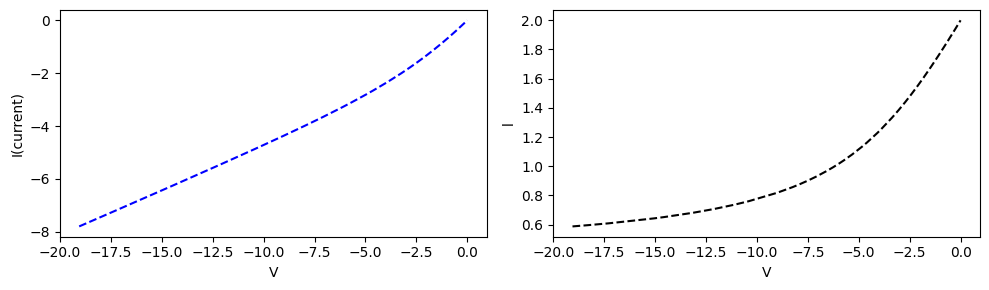

In [142]:
import matplotlib.pyplot as plt

# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

# Plot V vs. I
axs[0, 0].plot(V_sol_ord[:-end], I_sol_ord[:-end], color='blue', linestyle='--', markersize=2)
axs[0, 0].set_xlabel('V')
axs[0, 0].set_ylabel('I(current)')
# axs[0, 0].set_xlim(0.25, 8)  # Adjust the x-axis limits if needed
# axs[0, 0].set_ylim(-100, 120)  # Adjust the y-axis limits if needed

# Plot V vs. l
#axs[0, 1].scatter(V_sol_ord, l_sol_ord, s=1, c='black', marker='o')
#axs[0, 1].plot(V_sol_ord, l_sol_ord, color='black', linestyle='-', alpha=0.5)  
axs[0, 1].plot(V_sol_ord[:-end], l_sol_ord[:-end], color='black', linestyle='--', markersize=1)
axs[0, 1].set_xlabel('V')
axs[0, 1].set_ylabel('l')
# axs[0, 1].set_xlim(0.25, 8)  # Adjust the x-axis limits if needed
# axs[0, 1].set_ylim(-150, 100)  # Adjust the y-axis limits if needed

plt.tight_layout()  # Adjust subplots to prevent overlap
plt.show()


/tmp/ipykernel_108/1493697985.py:27: RuntimeWarning: divide by zero encountered in log
  J_k_0 = (l_0 - r_0) * ((-1) ** (k + 1) * V_vector + np.log(l_0) - np.log(r_0)) / (H1 * (np.log(l_0) - np.log(r_0)))
/tmp/ipykernel_108/1493697985.py:27: RuntimeWarning: invalid value encountered in divide
  J_k_0 = (l_0 - r_0) * ((-1) ** (k + 1) * V_vector + np.log(l_0) - np.log(r_0)) / (H1 * (np.log(l_0) - np.log(r_0)))


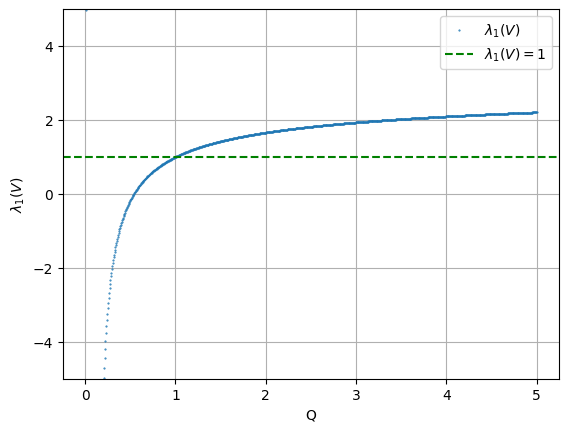

In [143]:
# It follows from above that one bifurcation point for \lambda_1 is
#  fancy_A, fancy_I, V0, fancy_l = 1.1532910778552934 -2.6788424376454416 -4.6747976631815895 1.153291093129064567
# Now, let assume Q0=1 is the corresponding point, i.e., \lambda_1(Q0,V0) = 1. Then, considering 
# equation 3.6 in the paper, A0 = fancy_A*Q0 = 1.1532910778552934, l0 = fancy_l*Q0 = 1.153291093129064567
# I0 = fancy_I*2Q0/H(a) = (-2.6788424376454416)*2/(1/3) = -16.07305462587265

# Therefore, the bifurcation point occurs at (Q0,V0) = (1,-4.6747976631815895).
# Now, let's draw \lambda_1(Q,V0) versus Q when Q varies from 0.0 to 5:

# Define constants
alpha = 1/3
Q_values = np.linspace(0.0, 5.0, 1000)
H1 = 1
l_0 = np.full_like(Q_values, l0)
I_0 = I0 * (2*Q_values/(alpha * H1) )
V_0 = V_sol_ord[100]
A_0 = A0 * Q_values
r_0 = r0 * Q_values

V_values = [V_0]

for V in range(len(V_values)):  
    V_vector = np.full_like(Q_values, V_values[V])
    
    F = 2 * (l_0 - A_0)/(alpha * H1)
    J_k = 0.5 * (F + (-1) ** (k + 1) * I_0)
    J_k_0 = (l_0 - r_0) * ((-1) ** (k + 1) * V_vector + np.log(l_0) - np.log(r_0)) / (H1 * (np.log(l_0) - np.log(r_0)))
    lmd_kk = J_k / J_k_0
    
    #print("Shape of V_vector:", V_vector.shape)
    

    plt.plot(Q_values, lmd_kk, label=r'$\lambda_1(V)$', linestyle='None', marker='.', markersize=1)

# Add horizontal line at lambda_k(V) = 1
plt.axhline(y=1, color='green', linestyle='--', label=r'$\lambda_1(V) = 1$')
# Add text on top of the horizontal line
#plt.text(5, 1.1, r'$\lambda_1(V) = 1$', fontsize=12, color='green')

plt.xlabel('Q')
plt.ylabel(r'$\lambda_1(V)$')
plt.ylim(-5, 5)
#plt.title('Plot of $\lambda_1(V)$ versus V')
plt.legend()
plt.grid(True)
plt.show()

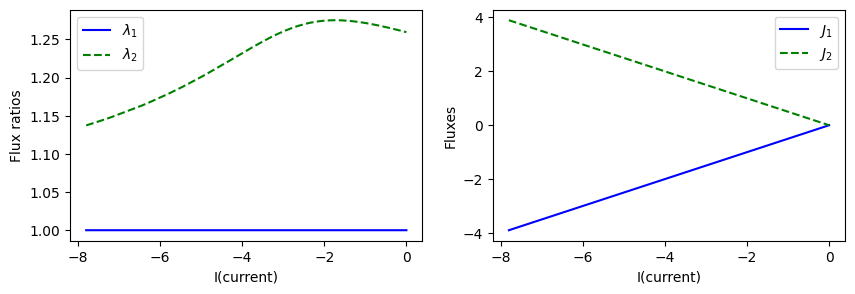

In [144]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

#axs[0, 0].scatter(I_sol_ord, lmd1, label='$\lambda_1$',s=5, color='red')
axs[0, 0].plot(I_sol_ord[:-end], lmd1[:-end], color='blue', linestyle='-', markersize=2, label='$\lambda_1$')
#axs[0, 0].scatter(I_sol_ord, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 0].plot(I_sol_ord[:-end], lmd2[:-end], color='green', linestyle='--', markersize=2, label='$\lambda_2$')
axs[0, 0].set_xlabel('I(current)')
axs[0, 0].set_ylabel('Flux ratios')
axs[0, 0].legend()
#axs[0, 0].set_xlim(left=-90)  # Adjust the x-axis limits
#axs[0, 0].set_ylim(.9, 1.3)  # Adjust the y-axis limits

#axs[0, 1].scatter(I_sol_ord, J1, label='$J_1$', s=5, color='red')
axs[0, 1].plot(I_sol_ord[:-end], J1[:-end], color='blue', linestyle='-', markersize=2, label='$J_1$')
#axs[0, 1].scatter(I_sol_ord, J2, label='$J_2$', s=5, color='blue')
axs[0, 1].plot(I_sol_ord[:-end], J2[:-end], color='green', linestyle='--', markersize=2, label='$J_2$')
axs[0, 1].set_xlabel('I(current)')
axs[0, 1].set_ylabel('Fluxes')
axs[0, 1].legend()
#axs[0, 1].set_xlim(left=-80) # Adjust the x-axis limits
#axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits

plt.show()

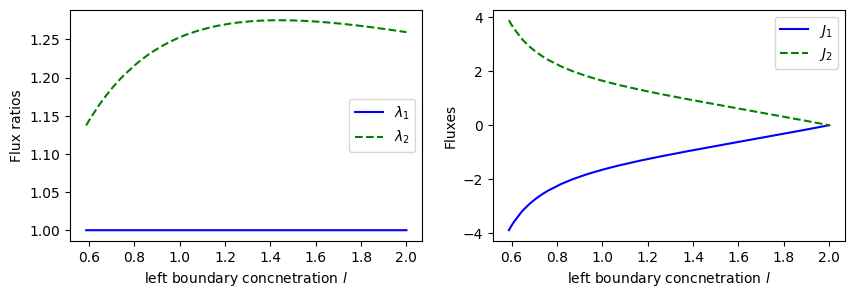

In [145]:
# plot the solutions
fig, axs = plt.subplots(1, 2, figsize=(10, 3), squeeze=False)

#axs[0, 0].scatter(I_sol_ord, lmd1, label='$\lambda_1$',s=5, color='red')
axs[0, 0].plot(l_sol_ord[:-end], lmd1[:-end], color='blue', linestyle='-', markersize=2, label='$\lambda_1$')
#axs[0, 0].scatter(I_sol_ord, lmd2, label='$\lambda_2$', s=5, color='blue')
axs[0, 0].plot(l_sol_ord[:-end], lmd2[:-end], color='green', linestyle='--', markersize=2, label='$\lambda_2$')
axs[0, 0].set_xlabel('left boundary concnetration $l$')
axs[0, 0].set_ylabel('Flux ratios')
axs[0, 0].legend()
#axs[0, 0].set_xlim(left=-90)  # Adjust the x-axis limits
#axs[0, 0].set_ylim(.9, 1.3)  # Adjust the y-axis limits

#axs[0, 1].scatter(I_sol_ord, J1, label='$J_1$', s=5, color='red')
axs[0, 1].plot(l_sol_ord[:-end], J1[:-end], color='blue', linestyle='-', markersize=2, label='$J_1$')
#axs[0, 1].scatter(I_sol_ord, J2, label='$J_2$', s=5, color='blue')
axs[0, 1].plot(l_sol_ord[:-end], J2[:-end], color='green', linestyle='--', markersize=2, label='$J_2$')
axs[0, 1].set_xlabel('left boundary concnetration $l$')
axs[0, 1].set_ylabel('Fluxes')
axs[0, 1].legend()
#axs[0, 1].set_xlim(left=-80) # Adjust the x-axis limits
#axs[0, 1].set_ylim(-50, 50)  # Adjust the y-axis limits

plt.show()

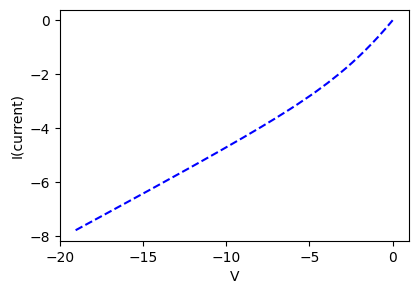

In [146]:
# plot the solutions
fig, axs = plt.subplots(1, 1, figsize=(4.5, 3), squeeze=False)

#axs[0, 0].scatter(V_sol_ord, I_sol_ord, s=5, c='green')
axs[0, 0].plot(V_sol_ord[:-end], I_sol_ord[:-end], color='blue', linestyle='--', markersize=2)
axs[0, 0].set_xlabel('V')
axs[0, 0].set_ylabel('I(current)')
#axs[0, 0].set_xlim(-100, 70)  # Adjust the x-axis limits
#axs[0, 0].set_ylim(-50, 100)  # Adjust the y-axis limits
# Plot lmd1 and lmd2 using scatter plots

plt.show()

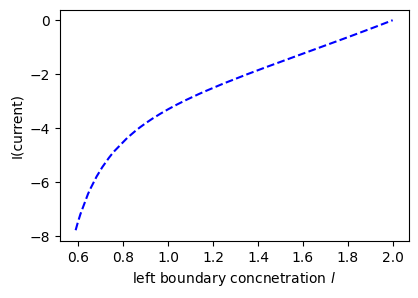

In [147]:
# plot the solutions
fig, axs = plt.subplots(1, 1, figsize=(4.5, 3), squeeze=False)

axs[0, 0].plot(l_sol_ord[:-end], I_sol_ord[:-end], color='blue', linestyle='--', markersize=2)
axs[0, 0].set_xlabel('left boundary concnetration $l$')
axs[0, 0].set_ylabel('I(current)')
#axs[0, 0].set_xlim(-100, 70)  # Adjust the x-axis limits
#axs[0, 0].set_ylim(-50, 100)  # Adjust the y-axis limits
# Plot lmd1 and lmd2 using scatter plots

plt.show()